In [2]:
import csv
import itertools
import random
import time
import math

import matplotlib.pyplot as plt
from typing import Tuple, List, Dict

In [3]:
# misc functions
def read_city_file(filename: str) -> Tuple[List[str], Dict[Tuple[str, str], float]]:
    """
    Read the csv file to get the city list and the city-to-city distance map.
    
    Args:
        filename (str): the filename.
    Returns:
        (tuple): a tuple containing the list of all the city names and a dictionary mapping
            a tuple of two cities (as strings) to a float value representing the distance between
            the two cities.
    """
    cities = None
    city_distances = {}

    with open(filename, "r") as csv_f:
        reader = csv.reader(csv_f, delimiter=";")
        city_idx = -1

        for row in reader:
            if cities is None:
                cities = row
            else:
                city_idx += 1
                cur_city = cities[city_idx]

                for city, distance in zip(cities, row):
                    city_distances[cur_city, city] = float(distance)
                    
    return cities, city_distances

def evaluate(solution: List[str]) -> float:
    """
    Evaluate a solution by computing the total distance of the city list permutation.
    
    Args:
        solution (list): a list of the cities making up the solution path.
    Returns:
        (float): the total distance of the solution path.
    """
    total_distance = 0
    for i in range(len(solution) - 1):
        total_distance += city_distances[(solution[i], solution[i+1])]
    total_distance += city_distances[solution[-1], solution[0]]
    return total_distance

In [4]:
cities, city_distances = read_city_file("european_cities.csv")

## Exhaustive search algorithm

In [5]:
def exhaustive(cities: List[str]) -> Tuple[List[str], float]:
    """
    Do an exhaustive search of all possible solutions of the input city list to find the shortest possible
    path.
    
    Args:
        cities (list): a list of the cities that are to be visited.
    Returns:
        (tuple): a tuple containing the shortest path permutation found and its distance.
    """
    shortest_solution = None
    shortest_distance = float("inf")
    
    for solution in itertools.permutations(cities):
        distance = evaluate(solution)
        
        if distance < shortest_distance:
            shortest_distance = distance
            shortest_solution = solution
            
    return shortest_solution, shortest_distance

In [6]:
# test exhaustive search
for num_cities in range(5, 11):
    s = time.time()
    solution, distance = exhaustive(cities[:num_cities])
    t = time.time() - s

    print(f"Compute time for {num_cities} cities: {round(t, 1)} seconds ({round((t * 1000000) / math.factorial(num_cities), 3)} microseconds/solution)")
    print(f"Shortest distance found: {round(distance, 3)} - with the solution:\n{solution}\n\n")

Compute time for 5 cities: 0.0 seconds (0.0 microseconds/solution)
Shortest distance found: 4983.38 - with the solution:
('Barcelona', 'Belgrade', 'Bucharest', 'Berlin', 'Brussels')


Compute time for 6 cities: 0.0 seconds (1.388 microseconds/solution)
Shortest distance found: 5018.81 - with the solution:
('Barcelona', 'Belgrade', 'Bucharest', 'Budapest', 'Berlin', 'Brussels')


Compute time for 7 cities: 0.0 seconds (1.19 microseconds/solution)
Shortest distance found: 5487.89 - with the solution:
('Berlin', 'Copenhagen', 'Brussels', 'Barcelona', 'Belgrade', 'Bucharest', 'Budapest')


Compute time for 8 cities: 0.0 seconds (1.215 microseconds/solution)
Shortest distance found: 6667.49 - with the solution:
('Brussels', 'Dublin', 'Barcelona', 'Belgrade', 'Bucharest', 'Budapest', 'Berlin', 'Copenhagen')


Compute time for 9 cities: 0.5 seconds (1.306 microseconds/solution)
Shortest distance found: 6678.55 - with the solution:
('Berlin', 'Copenhagen', 'Hamburg', 'Brussels', 'Dublin', 'Bar

## Genetic algorithm

### Pseudocode
***1&nbsp;&nbsp;population = create_random_solutions(population_size)<br/>
1&nbsp;&nbsp;fitness_scores = [evaluate(solution) for solution in population]<br/>
2&nbsp;&nbsp;for generation in range(number_of_generations):<br/>
3&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;parents = select_parents_based_on_fitness(population, fitness_scores)<br/>
4&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;children = crossover(parents)<br/>
5&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;children = mutate(children)<br/>
6&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;fitness_scores = [evaluate(solution) for solution in population]<br/>
7&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;best_solution, best_evaluation = find_best_solution(population, fitness_scores)<br/>
8&nbsp;&nbsp;return best_solution, best_evaluation***

**Note:**<br/>
For this genetic algorithm, a solution is a permutation of cities and the corresponding fitness is the total distance<br/>
of the route created by the permutation. Since we are searching for the shortest possible route, we are actually<br/>
trying to minimize the fitness.

### Crossover functions

In [42]:
def pmx(genome1: List[str], genome2: List[str]) -> List[str]:
    """
    Partially mapped crossover implementation that takes two genomes (solutions) and performs a crossover
    operation to create a new child solution.
    
    Implemented according to the description from:
    https://www.rubicite.com/Tutorials/GeneticAlgorithms/CrossoverOperators/PMXCrossoverOperator.aspx/
    
    Args:
        genome1 (list): the first parent solution used in the crossover.
        genome2 (list): the second parent solution used in the crossover.
    Returns:
        (list): the new child solution.
    """        
    length = len(genome1)
    
    # determine the segment that we copy from genome 1 into the child
    idx1 = random.randint(0, length - 1)
    idx2 = random.randint(0, length - 1)
    if idx1 > idx2: idx1, idx2 = idx2, idx1
        
    # start building the child genome by copying the determined segment from genome 1
    child = [None] * length
    child[idx1:idx2] = genome1[idx1:idx2]
    
    # look through the determined segment and find all elements in genome 2 that weren't copied to the child
    for i in range(idx1, idx2):
        ind = i
        if genome2[ind] not in child:
            while child[ind] != None:
                g1_elem = genome1[ind]
                g2_elem_pos = genome2.index(g1_elem)
                ind = g2_elem_pos
            child[ind] = genome2[i]
        
    # fill any remaining empty slots in the child from genome2
    for i in range(length):
        if child[i] == None:
            child[i] = genome2[i]
            
    return child

### Mutation functions

In [44]:
def swap_mutate(genome: List[str]) -> List[str]:
    """
    Mutate a genome by swapping two elements in the genome.
    
    Args:
        genome (list): the genome that is going to be mutated.
    Returns:
        (list): the mutated genome.
    """
    idx1, idx2 = random.randint(0, len(genome) - 1), random.randint(0, len(genome) - 1)
    genome[idx1], genome[idx2] = genome[idx2], genome[idx1]
    return genome

def shuffle_mutate(genome: List[str]) -> List[str]:
    """
    Mutate a genome by shuffling a randomly selected segment of the genome.
    
    Args:
        genome (list): the genome that is going to be mutated.
    Returns:
        (list): the mutated genome.
    """
    idx1, idx2 = random.randint(0, len(genome)), random.randint(0, len(genome))
    if idx1 > idx2: idx1, idx2 = idx2, idx1
    segment_copy = genome[idx1:idx2]
    random.shuffle(segment_copy)
    genome[idx1:idx2] = segment_copy
    return genome

def inversion_mutate(genome: List[str]) -> List[str]:
    """
    Mutate a genome by inverting a randomly selected segment of the genome.
    
    Args:
        genome (list): the genome that is going to be mutated.
    Returns:
        (list): the mutated genome.
    """
    idx1, idx2 = random.randint(0, len(genome)), random.randint(0, len(genome))
    if idx1 > idx2: idx1, idx2 = idx2, idx1
    genome[idx1:idx2] = genome[idx1:idx2][::-1]
    return genome

### Genetic algorithm misc

In [45]:
class Solution():
    """
    Solution class to store a single solution along with its fitness score
    """
    def __init__(self, permutation: List[str]):
        self.permutation = permutation
        self.fitness = None
        
    def compute_fitness(self):
        if self.fitness == None:
            self.fitness = evaluate(self.permutation)
    
    def __str__(self):
        return str(self.permutation)
        
def weighted_selection(population: List[Solution], num: int) -> List[Solution]:
    """
    Function to select num number of solutions from a population. The selection is weighted
    based off of the solutions' fitness scores.
    
    Args:
        population (list): the list of solutions.
        num (int): the number of solutions to select.
    Returns:
        (list): a list containing the selected solutions.
    """    
    # compute the probability weights used to select solutions from the population
    max_fitness = max([sol.fitness for sol in population])
    mean_fitness = sum([sol.fitness for sol in population]) / len(population)
    exps = [(math.exp((-sol.fitness + max_fitness) / mean_fitness)) for sol in population]
    weights = [e / sum(exps) for e in exps]
    
    # select num solutions
    selected = []
    for _ in range(num):
        pick, cur = random.uniform(0, sum(weights)), 0
        for i in range(len(population)):
            cur += weights[i]
            if cur > pick:
                selected.append(population[i])
                break
                
    return selected

In [46]:
def genetic_algorithm(cities: List[str], population_size=500, mutation_rate=0.15, generations=200) -> Tuple[List[str], float, Dict[str, List[float]]]:
    """
    A genetic algorithm to search for the best possible solution to the TSP.
    
    Args:
        cities (list): the list of cities.
        population_size (int): the number of solutions evaluated per generation.
        mutation_rate (float): the rate of how many of newly created child solutions will be mutated.
        generations (int): the number of generations to run the algorithm for.
    Returns:
        (tuple): a tuple containing the shortest path permutation found and its distance.
    """
    best_solution = None
    best_distance = float("inf")
    data = {"best_distance": [], "mean_distance": []}
    
    # initialize the population with random solutions and compute each solutions' fitness
    population = []
    for _ in range(population_size):
        solution = Solution(cities.copy())
        random.shuffle(solution.permutation)
        solution.compute_fitness()
        population.append(solution)
    
    # run generations
    for gen in range(generations):
        # select parents
        parents = weighted_selection(population, int(len(population) / 2))
        
        # create children
        children = [Solution(pmx(random.choice(parents).permutation, random.choice(parents).permutation)) for _ in range(len(population) - len(parents))]
        
        # mutate the children
        for i in range(len(children)):
            if random.uniform(0, 1) >= mutation_rate:
                # 1/3 chance of using each of the mutation functions
                roll = random.randint(0, 2)
                if roll == 0:
                    children[i].permutation = swap_mutate(children[i].permutation)
                if roll == 1:
                    children[i].permutation = shuffle_mutate(children[i].permutation)
                if roll == 2:
                    children[i].permutation = inversion_mutate(children[i].permutation)
        
        # create the new population and select which to remove to restore the correct population size
        population = population + children
        
        # save relevant data for the generation
        generation_min_fitness = float("inf")
        generation_total_fitness = 0
        generation_mean_fitness = None
        
        # evaluate the new population
        for i in range(len(population)):
            population[i].compute_fitness()
                
            # update the best known solution so far
            generation_total_fitness += population[i].fitness
            generation_min_fitness = min(generation_min_fitness, population[i].fitness)
            if population[i].fitness < best_distance:
                best_solution = population[i].permutation
                best_distance = population[i].fitness
                
        # save data
        generation_mean_fitness = generation_total_fitness / len(population)
        data["best_distance"].append(generation_min_fitness)
        data["mean_distance"].append(generation_mean_fitness)
        
        # to include enough exploitation we remove the worst found solution in the population until
        # the correct size is restored
        fitness_scores = [solution.fitness for solution in population]
        while len(population) > population_size:
            worst_fitness = max(fitness_scores)
            worst_idx = fitness_scores.index(worst_fitness)
            del population[worst_idx], fitness_scores[worst_idx]
                           
    return best_solution, best_distance, data

Settings: [cities: 24, population size: 500, mutation rate: 0.15, generations: 500]
Compute time: 5.4 seconds
Shortest distance found: 12287.07 - with the solution:
['Rome', 'Barcelona', 'Madrid', 'Dublin', 'London', 'Paris', 'Brussels', 'Hamburg', 'Copenhagen', 'Stockholm', 'Saint Petersburg', 'Moscow', 'Kiev', 'Bucharest', 'Istanbul', 'Sofia', 'Belgrade', 'Budapest', 'Vienna', 'Warsaw', 'Berlin', 'Prague', 'Munich', 'Milan']




Text(0, 0.5, 'Fitness')

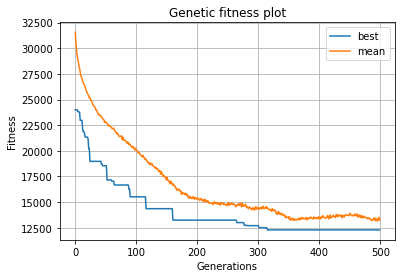

In [55]:
num_cities = 24
population_size = 500
mutation_rate = 0.15
generations = 500

s = time.time()
solution, distance, data = genetic_algorithm(cities[:num_cities], population_size, mutation_rate, generations)
t = time.time() - s

print(f"Settings: [cities: {num_cities}, population size: {population_size}, mutation rate: {mutation_rate}, generations: {generations}]")
print(f"Compute time: {round(t, 1)} seconds")
print(f"Shortest distance found: {round(distance, 3)} - with the solution:\n{solution}\n\n")

plt.plot([i for i in range(len(data["best_distance"]))], data["best_distance"], label="best")
plt.plot([i for i in range(len(data["mean_distance"]))], data["mean_distance"], label="mean")
plt.legend()
plt.grid()
plt.title("Genetic fitness plot")
plt.xlabel("Generations")
plt.ylabel("Fitness")